In [1]:
# Import 
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import pdb

# settings
torch.manual_seed(1234)
with_augs = False
lr = 0.001
with_norm = False
num_epochs = 10

# Res
# False, 0.001, False, 10: Accuracy train: 94.8%    test: 93.3%
# False, 0.001, True, 10: Accuracy train: 94.4%    test: 92.9%
# True, 0.001, True, 10: Accuracy train: 96.1%    test: 92.9%
# True, 0.001, True, 10: Accuracy train: 95.7%    test: 93.2%



# Get CUDA
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Define Hotdog data class
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/dtu/datasets1/02514/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y


# Load data
size = 224
train_test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5226-0.5226*(1.0*with_norm), 0.4412-0.4412*(1.0*with_norm), 0.3585-0.3585*(1.0*with_norm)), 
                                                         (0.0036+(1-0.0036)*(1.0*with_norm), 0.0036+(1-0.0036)*(1.0*with_norm), 0.0050+(1-0.0050)*(1.0*with_norm)))
                                    ])
train_transform_aug = transforms.Compose([transforms.Resize((size, size)), 
                                          transforms.RandomRotation(degrees=30),
                                          transforms.RandomCrop(200, padding=(12,12)),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5226-0.5226*(1.0*with_norm), 0.4412-0.4412*(1.0*with_norm), 0.3585-0.3585*(1.0*with_norm)), 
                                                         (0.0036+(1-0.0036)*(1.0*with_norm), 0.0036+(1-0.0036)*(1.0*with_norm), 0.0050+(1-0.0050)*(1.0*with_norm)))
                                          ])

batch_size = 4
trainset = Hotdog_NotHotdog(train=True, transform=train_test_transform)
trainset_aug = Hotdog_NotHotdog(train=True, transform=train_test_transform)
if with_augs:
    trainset= torch.utils.data.ConcatDataset([trainset, trainset_aug])
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

testset = Hotdog_NotHotdog(train=False, transform=train_test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)


# Get model
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
# Freeze parameters for pretrained model (to avoid overfitting)
for param in efficientnet.parameters():
    param.requires_grad = False
efficientnet.to(device)

# Change model classifier to hotdog/notdog (don't freeze params of last layer)
num_ftrs = efficientnet.classifier.fc.in_features
efficientnet.classifier.fc = nn.Linear(num_ftrs, 2)

# Set optimizer and model
model = efficientnet.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

def loss_fun(output, target):
    crit = nn.CrossEntropyLoss()
    return crit(output, target)

out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    train_loss = []
    model.train()
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = loss_fun(output, target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        train_loss.append(loss.cpu().item())
        #Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    model.eval()
    test_loss = []
    test_correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        test_loss.append(loss_fun(output, target).cpu().item())
        predicted = output.argmax(1)
        test_correct += (target==predicted).sum().cpu().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)

    out_dict['train_acc'].append(train_correct/len(trainset))
    out_dict['test_acc'].append(test_correct/len(testset))
    out_dict['train_loss'].append(np.mean(train_loss))
    out_dict['test_loss'].append(np.mean(test_loss))
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

    


The code will run on GPU.


Using cache found in /zhome/0c/5/127579/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/zhome/0c/5/127579/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/zhome/0c/5/127579/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"


  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 81.5%	 test: 92.3%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 84.4%	 test: 92.2%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 85.2%	 test: 92.5%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 84.9%	 test: 92.5%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 85.8%	 test: 92.7%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 84.3%	 test: 92.2%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 85.1%	 test: 91.5%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 86.0%	 test: 91.4%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 84.7%	 test: 91.6%


  0%|          | 0/512 [00:00<?, ?it/s]

Accuracy train: 84.7%	 test: 91.9%


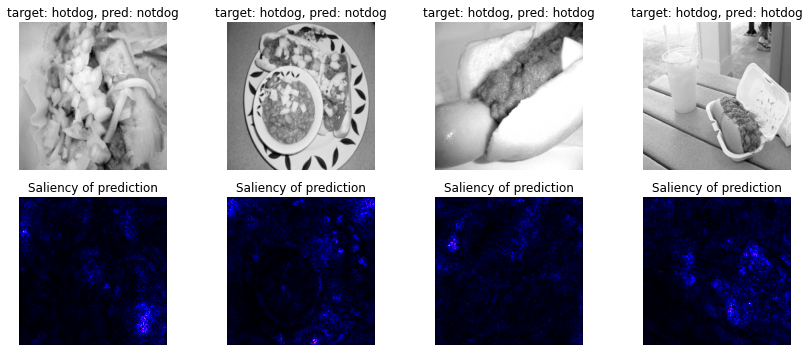

In [26]:
# Saliency for same images
test_count = 0
fig, axs = plt.subplots(2,4,figsize=(12,5), gridspec_kw={'height_ratios': [1, 1]})

for data, target in test_loader:
    data = data.to(device)
    data.requires_grad_()
    output = efficientnet(data)
    predicted = output.argmax(1).cpu()
    
    # Catch the output
    output_idx = output.argmax(dim=1)

    for i in range(len(target)-2):
        if target[i]!=predicted[i]:
            # Do backpropagation to get the derivative of the output based on the image
            output_max = output[i,output_idx[i]]
            output_max.backward(retain_graph=True)
            saliency, _ = torch.max(data.grad.data[i].abs(), dim=0) 
            saliency = saliency.reshape(size, size)
            saliency = (saliency-torch.min(saliency))/(torch.max(saliency)-torch.min(saliency))

            axs.flatten()[test_count+4].imshow(saliency.cpu().numpy(), 'gnuplot2')
            axs.flatten()[test_count+4].set_title(f'Saliency of prediction')
            axs.flatten()[test_count+4].axis('off')

            axs.flatten()[test_count].imshow(data[i].detach().cpu().numpy()[0], 'gray')
            axs.flatten()[test_count].set_title(f'target: {"hotdog" if target[i].item() == 0 else "notdog"}, pred: {"hotdog" if predicted[i].item() == 0 else "notdog"}')
            axs.flatten()[test_count].axis('off')

            
            test_count += 1
    
        if test_count == 2:
            break;
    if test_count == 2:
        break;


for data, target in test_loader:
    data = data.to(device)
    data.requires_grad_()
    output = efficientnet(data)
    predicted = output.argmax(1).cpu()

    # Catch the output
    output_idx = output.argmax(dim=1)

    for i in range(len(target)):
        if target[i]==predicted[i]:
            # Do backpropagation to get the derivative of the output based on the image
            output_max = output[i,output_idx[i]]
            output_max.backward(retain_graph=True)
            saliency, _ = torch.max(data.grad.data[i].abs(), dim=0) 
            saliency = saliency.reshape(size, size)
            saliency = (saliency-torch.min(saliency))/(torch.max(saliency)-torch.min(saliency))
            axs.flatten()[test_count+4].imshow(saliency.cpu().numpy(), 'gnuplot2')
            axs.flatten()[test_count+4].set_title(f'Saliency of prediction')
            axs.flatten()[test_count+4].axis('off')

            axs.flatten()[test_count].imshow(data[i].detach().cpu().numpy()[0], 'gray')
            axs.flatten()[test_count].set_title(f'target: {"hotdog" if target[i].item() == 0 else "notdog"}, pred: {"hotdog" if predicted[i].item() == 0 else "notdog"}')
            axs.flatten()[test_count].axis('off')
            
            test_count += 1
    
        if test_count == 4:
            break;
    if test_count == 4:
        break;
#plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, hspace=0.2, wspace=0.02)
plt.tight_layout()
plt.savefig('saliency.png')


In [ ]:
out_dict